# Homomorphic encryption simulation with the simplified simulator

In this notebook we show an example of how to simulate the quantum homomorphic encryption of an artificial circuit with the simplified simulator from [[1]](https://arxiv.org/abs/2412.01966) in order to check that the results are the same as with the realistic simulator.

## Table of Contents

- [Packages](#0)
- [1 - Example circuit](#1)
- [2 - Homomorphic simulation](#2)
- [3 - Simplified homomorphic simulation](#3)
- [4 - References](#4)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator library.

In [1]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram, plot_distribution

from qiskit_aer import AerSimulator

import cqc_qhe as cqc

The code has been tested on qiskit 1.1.0, and qiskit-aer 0.14.1.

In [2]:
import qiskit
qiskit.__version__

'1.1.0'

In [3]:
import qiskit_aer
qiskit_aer.__version__

'0.14.2'

<a name='1'></a>
## 1 - Example circuit

First, we construct the circuit that produces the initial state, and is run by Client.

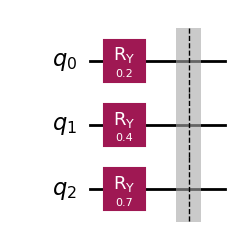

In [4]:
qr = QuantumRegister(3,'q')

init_circ = QuantumCircuit(qr)
# init_circ.h(range(3))
init_circ.ry(0.2,0)
init_circ.ry(0.4,1)
init_circ.ry(0.7,2)
init_circ.barrier()

init_circ.draw('mpl')

The circuit that Server muts run contains also measurement and reset operations.

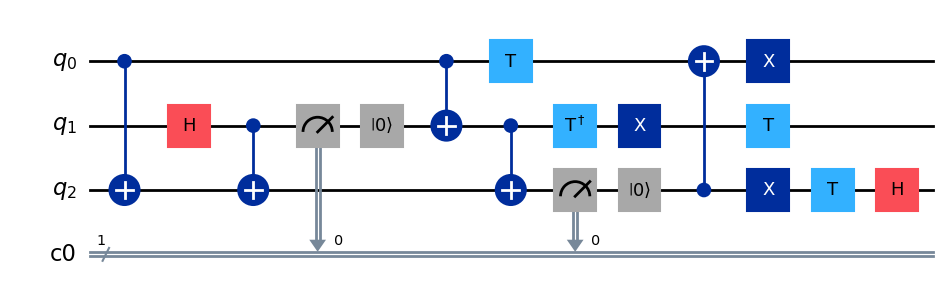

In [5]:
cr = ClassicalRegister(1)
main_circ = QuantumCircuit(qr,cr)


main_circ.cx(0,2)
main_circ.h(1)
main_circ.cx(1,2)
main_circ.measure(1,0)
main_circ.reset(1)
main_circ.cx(0,1)
main_circ.cx(1,2)
main_circ.measure(2,0)
main_circ.reset(2)
main_circ.tdg(1)
main_circ.t(0)
main_circ.cx(2,0)
main_circ.x(range(3))
main_circ.t(2)
main_circ.t(1)
main_circ.h(2)

main_circ.draw('mpl')

We compose the circuits and simulate it.

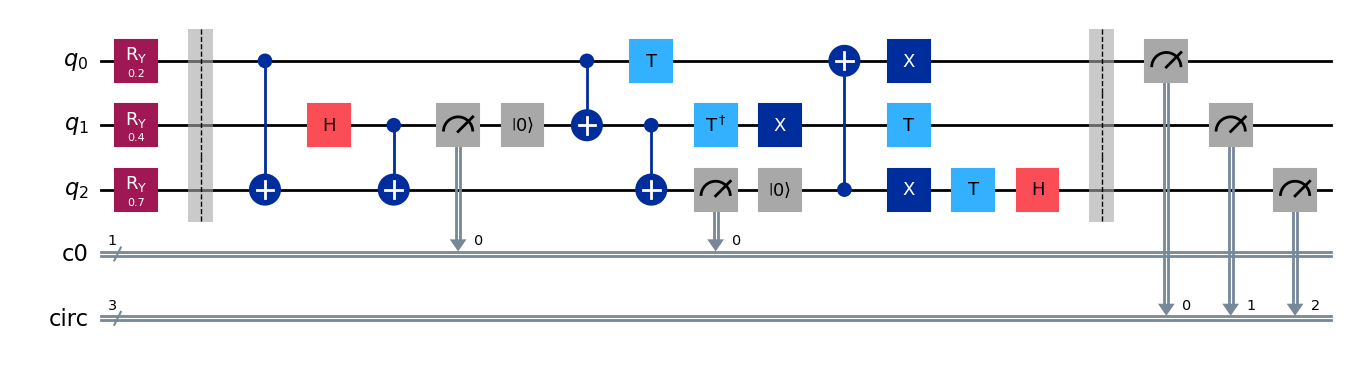

In [6]:
# Compose the circuits.
simulation_circ = main_circ.copy()
simulation_circ = simulation_circ.compose(init_circ,front=True,qubits=init_circ.qubits)

# Set the qubits for the results.
measured_qubits = qr

# Measure the qubits in a classical register.
circ_classical_reg = ClassicalRegister(len(measured_qubits),'circ')
simulation_circ.add_register(circ_classical_reg)
simulation_circ.barrier()
simulation_circ.measure(measured_qubits,circ_classical_reg)

simulation_circ.draw('mpl',filename='example_circuit.pdf')

Qiskit uses little-endian order for the bits, so that when measuring, the first bit in the result is the one at bottom. However, in our library CQC-QHE [[1]](https://arxiv.org/abs/2412.01966) we use big-endian order, so that the uppermost bit is the first one. To obtain the results in the correct order, we use our function ``run``. Moreover, since there are classical bits for the intermediate measurements, we need to take only the last classical register with our function ``last_register_counts``.

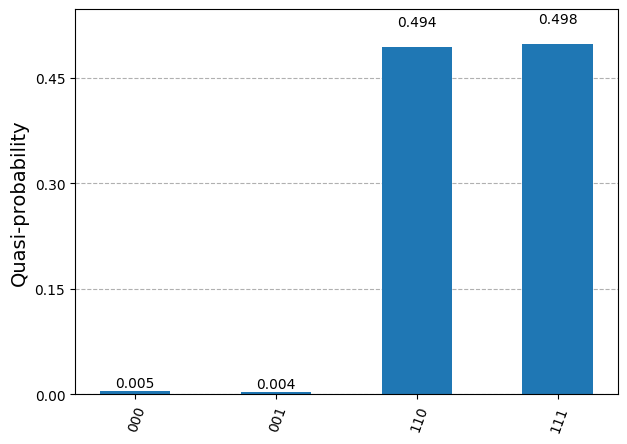

In [7]:
# shots = 1024
shots = 20000

counts = cqc.run_circuit(simulation_circ,shots)
counts = cqc.last_register_counts(counts)
plot_distribution(counts)

<a name='2'></a>
## 2 - Homomorphic simulation

For the homomorphic simulation, we need to create a circuit that first implements the initial circuit of Client, then the circuit of Server with the appropiate rules for the $T/T^\dagger$ gates and creation of Bell pairs in the ancilla qubits, and finally the circuit of Client that updates the keys and measures the final state.

We use the function ``create_homomorphic_circuit``.

In [8]:
# h_shots = 1024
h_shots = 20000

homomorphic_circuit = cqc.create_homomorphic_circuit(init_circ,main_circ,measured_qubits)

# homomorphic_circuit.draw('mpl')
len(homomorphic_circuit.qubits)

11

We run the circuit. As it has 11 qubits, it takes far more time than before.

In this case, the results have several classical registers in the bitstrings. The measurements of the qubits of the main circuit correspond to the last register. We take the counts of this classical register with the function ``last_register_counts``.

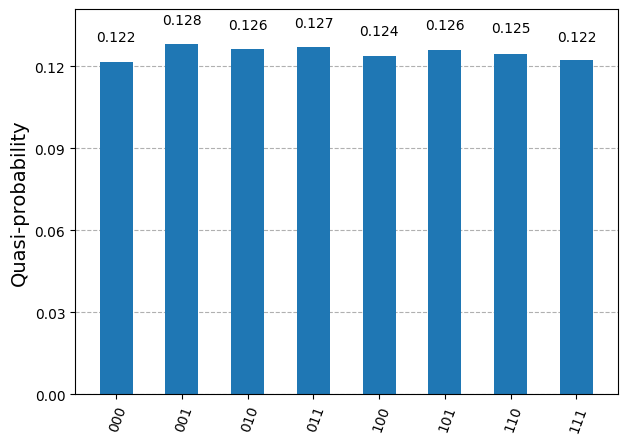

In [9]:
homomorphic_counts = cqc.run_circuit(homomorphic_circuit,h_shots)

encrypted_counts = cqc.last_register_counts(homomorphic_counts)

plot_distribution(encrypted_counts)

The results are encrypted, so we do not obtain the correct results obtained before. We decrypt them with the function ``decrypt_counts``.

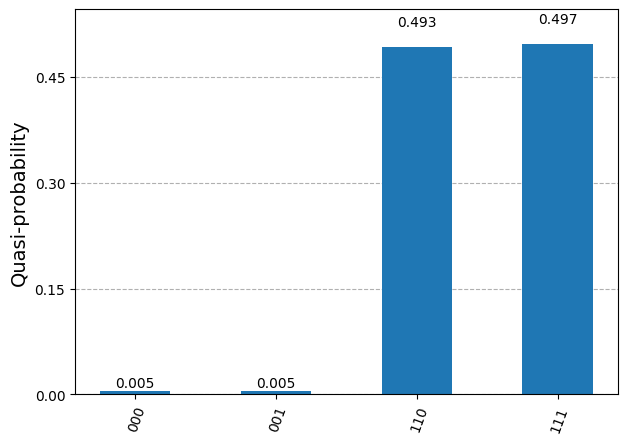

In [10]:
measured_positions = [0,1,2]

decrypted_counts = cqc.decrypt_counts(homomorphic_counts,measured_positions)

plot_distribution([decrypted_counts])

Now we obtain the correct results, being the same as for the circuit withouth the QHE scheme

<a name='3'></a>
## 3 - Simplified homomorphic simulation

The homomorphic circuit contains 11 qubits, since we need 2 qubits for each of the 4 $T/T^\dagger$ gates, plus the 3 original qubits. In the supplementary material of [[1]](https://arxiv.org/abs/2412.01966) we show a method for simplifying the simulation using only 2 qubits for all the $T/T^\dagger$ gates. We create this simplified circuit with the function ``create_simplified_homomorphic_circuit``.

In [11]:
simplified_homomorphic_circuit = cqc.create_simplified_homomorphic_circuit(init_circ,main_circ,measured_qubits)

# simplified_homomorphic_circuit.draw('mpl')

When running the circuit, we obtain similar results to the realistic homomorphic circuit. However, it takes much less time.

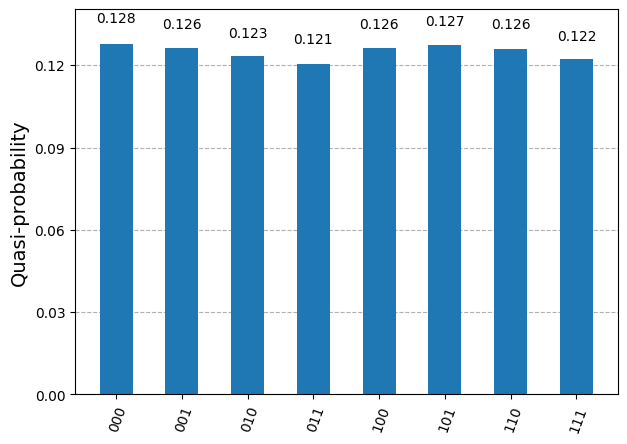

In [12]:
simplified_homomorphic_counts = cqc.run_circuit(simplified_homomorphic_circuit,h_shots)

simplified_encrypted_counts = cqc.last_register_counts(simplified_homomorphic_counts)

plot_distribution(simplified_encrypted_counts)

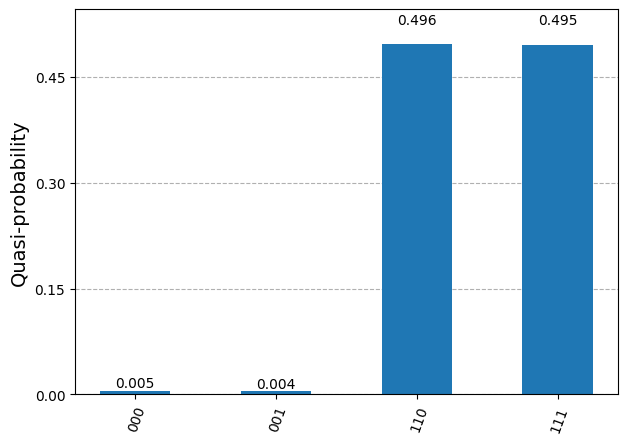

In [13]:
measured_positions = [0,1,2]

simplified_decrypted_counts = cqc.decrypt_counts(simplified_homomorphic_counts,measured_positions)

plot_distribution([simplified_decrypted_counts])

Thus, we have verified that the simplified circuit is valid for the homomorphic encryption scheme simulation.

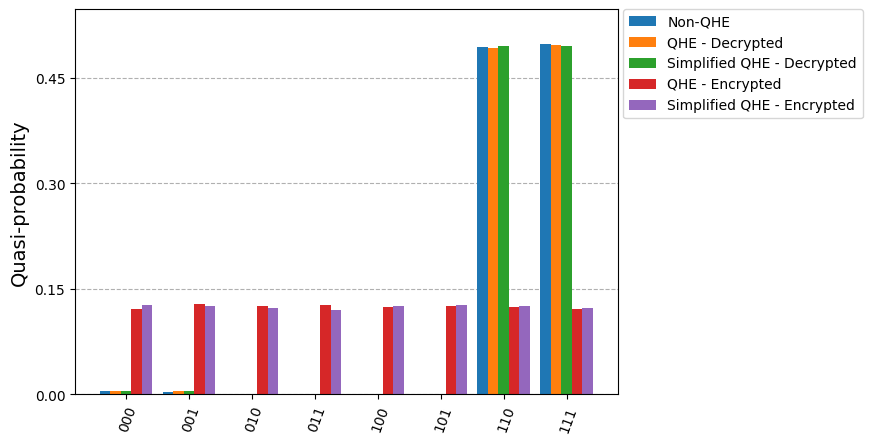

In [14]:
legend = ['Non-QHE','QHE - Decrypted','Simplified QHE - Decrypted','QHE - Encrypted','Simplified QHE - Encrypted']
plot_distribution([counts,decrypted_counts,simplified_decrypted_counts,encrypted_counts,simplified_encrypted_counts],legend=legend,bar_labels=False)

<a name='4'></a>
## 4 - References

- [1] **[S. A Ortega, P. Fernández and M. A. Martin-Delgado. Implementing Semiclassical Szegedy Walks in Classical-Quantum Circuits for Homomorphic Encryption. arXiv:2412.01966](https://arxiv.org/abs/2412.01966)**